# Import libs

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from pymssa import MSSA
from chaos_indic import HurstTraj, NoiseFactor, DimEmb, max_lyapunov, fourier_harmonic_count, ks_entropy_partition
from tqdm import tqdm
import os
import nolds
import seaborn as sns


from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

# EDA

In [29]:
m4_datasets = pd.read_csv('/Users/roman14/Downloads/Reservoir-Computing-Investigation/M4 Competition Dataset/m4_info.csv')
m4_datasets.head()

,M4id,category,Frequency,Horizon,SP,StartingDate
0,Y1,Macro,1,6,Yearly,01-01-79 12:00
1,Y2,Macro,1,6,Yearly,01-01-79 12:00
2,Y3,Macro,1,6,Yearly,01-01-79 12:00
3,Y4,Macro,1,6,Yearly,01-01-79 12:00
4,Y5,Macro,1,6,Yearly,01-01-79 12:00


In [30]:
m4_datasets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   M4id          100000 non-null  object
 1   category      100000 non-null  object
 2   Frequency     100000 non-null  int64 
 3   Horizon       100000 non-null  int64 
 4   SP            100000 non-null  object
 5   StartingDate  100000 non-null  object
dtypes: int64(2), object(4)
memory usage: 4.6+ MB


In [31]:
m4_datasets['category'].value_counts(normalize=True)

category
Micro          0.25121
Finance        0.24534
Macro          0.19402
Industry       0.18798
Demographic    0.08708
Other          0.03437
Name: proportion, dtype: float64

In [32]:
m4_datasets['SP'].value_counts()

SP
Monthly      48000
Quarterly    24000
Yearly       23000
Daily         4227
Hourly         414
Weekly         359
Name: count, dtype: int64

In [33]:
m4_datasets.groupby(by=['category','SP']).count()['M4id']

category     SP       
Demographic  Daily           10
             Monthly       5728
             Quarterly     1858
             Weekly          24
             Yearly        1088
Finance      Daily         1559
             Monthly      10987
             Quarterly     5305
             Weekly         164
             Yearly        6519
Industry     Daily          422
             Monthly      10017
             Quarterly     4637
             Weekly           6
             Yearly        3716
Macro        Daily          127
             Monthly      10016
             Quarterly     5315
             Weekly          41
             Yearly        3903
Micro        Daily         1476
             Monthly      10975
             Quarterly     6020
             Weekly         112
             Yearly        6538
Other        Daily          633
             Hourly         414
             Monthly        277
             Quarterly      865
             Weekly          12
             Year

In [87]:
def list_train_csv_files(directory='.'):
    """
    Lists all files in the given directory that end with '-train.csv' and returns their count and names.
    
    Parameters:
        directory (str): Path to the directory to search. Defaults to current directory.
        
    Returns:
        tuple: (count of matching files, list of matching filenames)
    """
    files = os.listdir(directory)
    train_files = [f for f in files if f.endswith('-train.csv')]
    return len(train_files), train_files


len_train_files, files = list_train_csv_files(os.getcwd() + '/M4 Competition Dataset')
print(f"Found {len_train_files} '-train.csv' files:")
for file in files:
    print(file)


Found 6 '-train.csv' files:
Weekly-train.csv
Daily-train.csv
Hourly-train.csv
Monthly-train.csv
Yearly-train.csv
Quarterly-train.csv


# Get statistics

In [35]:
# Define desired proportions and counts for 650 samples
proportions = m4_datasets['category'].value_counts(normalize=True).to_dict()
total_to_sample = 650
desired_counts = {cat: int(round(p * total_to_sample)) for cat, p in proportions.items()}

# Sample by category
selected_frames = []
for cat, count in desired_counts.items():
    pool = m4_datasets[m4_datasets['category'] == cat]
    selected = pool.sample(n=count, random_state=23)
    selected_frames.append(selected)

selected_info = pd.concat(selected_frames).reset_index(drop=True)

In [36]:
selected_info.head()

,M4id,category,Frequency,Horizon,SP,StartingDate
0,Q6123,Micro,4,8,Quarterly,01-01-05 12:00
1,Q6855,Micro,4,8,Quarterly,01-01-98 12:00
2,M19903,Micro,12,18,Monthly,31-01-10 12:00
3,M15162,Micro,12,18,Monthly,31-01-94 12:00
4,Y9267,Micro,1,6,Yearly,31-12-77 12:00


In [37]:
selected_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   M4id          649 non-null    object
 1   category      649 non-null    object
 2   Frequency     649 non-null    int64 
 3   Horizon       649 non-null    int64 
 4   SP            649 non-null    object
 5   StartingDate  649 non-null    object
dtypes: int64(2), object(4)
memory usage: 30.6+ KB


In [168]:
selected_info['SP'].value_counts()

SP
Monthly      300
Yearly       165
Quarterly    157
Daily         24
Hourly         2
Weekly         1
Name: count, dtype: int64

In [169]:
selected_info['category'].value_counts()

category
Micro          163
Finance        159
Macro          126
Industry       122
Demographic     57
Other           22
Name: count, dtype: int64

In [ ]:

def collect_series(file_list, min_obs=850, target_n=650):
    """
    Iterate over CSVs in file_list, selecting columns with at least min_obs
    non-NaN values, until we have target_n series. Returns a DataFrame whose
    columns are the selected series.
    
    file_list : list of filenames (strings)
    min_obs    : minimum non-NaN count per series
    target_n   : total series to collect
    """
    collected = pd.DataFrame()  # will hold selected columns
    collected_count = 0
    
    for fname in file_list:
        if collected_count >= target_n:
            break
        
        # 1) Load and promote row 0 to header
        df = pd.read_csv(os.path.join(os.getcwd() + '/M4 Competition Dataset',fname))
        df = df.T
        df.reset_index(inplace=True, drop=True)
        df.columns = df.iloc[0]          # first row becomes header
        df.drop(df.index[0], inplace=True)
        
        # 2) For each column, count non-NaNs
        for col in df.columns:
            if collected_count >= target_n:
                break
            
            non_nans = df[col].notna().sum()
            if non_nans >= min_obs:
                # add this column to collected (align on index length)
                # pad shorter series with NaN if needed
                series = df[col]
                if len(series) < min_obs:
                    continue  # shouldn't happen, but guard
                # if collected is empty, initialize with index
                if collected_count == 0:
                    collected = pd.DataFrame(index=range(len(series)))
                # pad/truncate to collected.index length
                L = len(collected)
                s = series.reset_index(drop=True)
                if len(s) > L:
                    s = s.iloc[:L]
                elif len(s) < L:
                    s = s.reindex(range(L))
                collected[col] = s
                collected_count += 1
        
    print(f"Collected {collected_count} series out of requested {target_n}.")
    return collected

result_df = collect_series(files, min_obs=850, target_n=650)
print("Resulting DataFrame shape:", result_df.shape)


/var/folders/_2/3r2pyzk16rdbwgbf6s6rlngr0000gn/T/ipykernel_62840/1419046060.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  collected[col] = s
/var/folders/_2/3r2pyzk16rdbwgbf6s6rlngr0000gn/T/ipykernel_62840/1419046060.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  collected[col] = s
/var/folders/_2/3r2pyzk16rdbwgbf6s6rlngr0000gn/T/ipykernel_62840/1419046060.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider

Collected 650 series out of requested 650.
Resulting DataFrame shape: (2597, 650)


/var/folders/_2/3r2pyzk16rdbwgbf6s6rlngr0000gn/T/ipykernel_62840/1419046060.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  collected[col] = s
/var/folders/_2/3r2pyzk16rdbwgbf6s6rlngr0000gn/T/ipykernel_62840/1419046060.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  collected[col] = s
/var/folders/_2/3r2pyzk16rdbwgbf6s6rlngr0000gn/T/ipykernel_62840/1419046060.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider

In [39]:
time_series_df = result_df.dropna()
time_series_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 860 entries, 0 to 859
Columns: 650 entries, W1 to D818
dtypes: object(650)
memory usage: 4.3+ MB


In [40]:
for col in time_series_df.columns:
    try:
        time_series_df[col] = pd.to_numeric(time_series_df[col], errors='raise')
    except ValueError:
        # skip columns that aren’t pure numbers
        pass

/var/folders/_2/3r2pyzk16rdbwgbf6s6rlngr0000gn/T/ipykernel_62840/3674975952.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_series_df[col] = pd.to_numeric(time_series_df[col], errors='raise')


In [41]:
time_series_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 860 entries, 0 to 859
Columns: 650 entries, W1 to D818
dtypes: float64(650)
memory usage: 4.3 MB


In [42]:
# time_series_df.to_csv('time_series.csv', header=True)

## Measures

In [43]:
estimations = []

for series_name in tqdm(time_series_df.columns):
    # Only process if enough data points
    if len(time_series_df[series_name]) < 1:
        continue
    
    # Compute metrics
    _, _, hurst_exponent, _ = HurstTraj(time_series_df[series_name])
    noise = NoiseFactor(time_series_df[series_name])
    _, corr_dim, _ = DimEmb(time_series_df[series_name])
    lyap_max = max_lyapunov(time_series_df[series_name].values)
    ks_ent = ks_entropy_partition(time_series_df[series_name])
    fourier_count = fourier_harmonic_count(time_series_df[series_name])
    
    estimations.append({
        'series': series_name,
        'hurst': hurst_exponent,
        'noise_factor': noise,
        'corr_dim': corr_dim,
        'lyap_max': lyap_max,
        'ks_entropy': ks_ent,
        'fourier_harmonics': fourier_count
    })

measures_df = pd.DataFrame(estimations)

100%|██████████| 650/650 [46:54<00:00,  4.33s/it]  


In [45]:
measures_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 650 entries, 0 to 649
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   series             650 non-null    object 
 1   hurst              650 non-null    float64
 2   noise_factor       650 non-null    float64
 3   corr_dim           650 non-null    float64
 4   lyap_max           650 non-null    float64
 5   ks_entropy         650 non-null    float64
 6   fourier_harmonics  650 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 35.7+ KB


In [46]:
measures_df.head()

,series,hurst,noise_factor,corr_dim,lyap_max,ks_entropy,fourier_harmonics
0,W1,0.797709,0.980709,1.108239,0.042732,2.531081,93
1,W2,0.828420,0.980308,2.292996,0.042836,2.504099,99
2,W3,0.924993,0.971112,1.617081,0.008785,0.790687,97
3,W4,0.639750,0.726201,6.117816,0.131341,11.729851,121
4,W5,0.598976,0.287931,9.779273,0.078597,19.575970,203


In [50]:
measures_df.describe()

,hurst,noise_factor,corr_dim,lyap_max,ks_entropy,fourier_harmonics
count,650.000000,650.000000,650.000000,650.000000,650.000000,650.000000
mean,0.808612,0.899222,3.662117,0.070759,7.054416,79.593846
std,0.116557,0.130133,1.509545,0.039935,3.198148,32.097568
min,0.339814,-0.101800,0.182387,0.002838,0.403957,23.000000
25%,0.739372,0.909535,2.772141,0.057235,5.218469,57.000000
50%,0.827517,0.933269,3.522414,0.067764,6.556279,73.000000
75%,0.899012,0.955773,4.383327,0.077714,7.781012,93.000000
max,1.071351,0.988990,15.953856,0.650864,20.813726,287.000000


In [ ]:
# measures_df.to_csv('measures_df.csv', header=True)

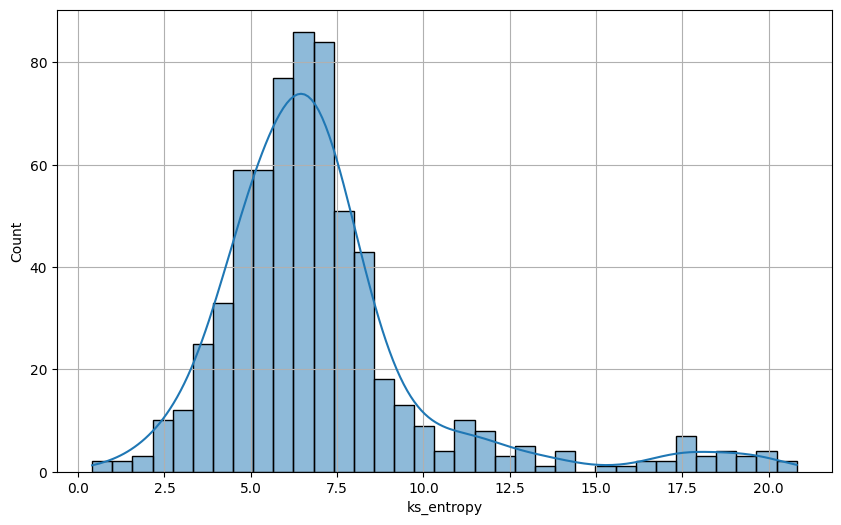

In [51]:
plt.figure(figsize=(10,6))
sns.histplot(measures_df['ks_entropy'], kde=True)
plt.grid()

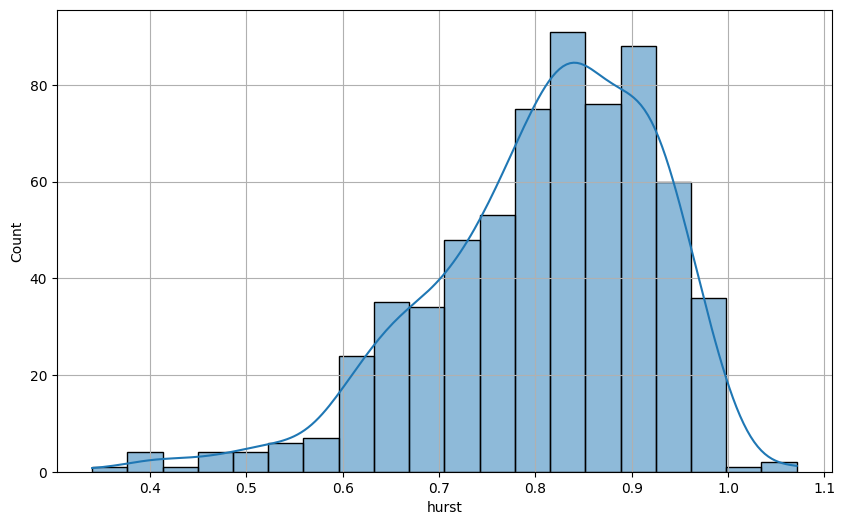

In [58]:
plt.figure(figsize=(10,6))
sns.histplot(measures_df['hurst'], kde=True)
plt.grid()

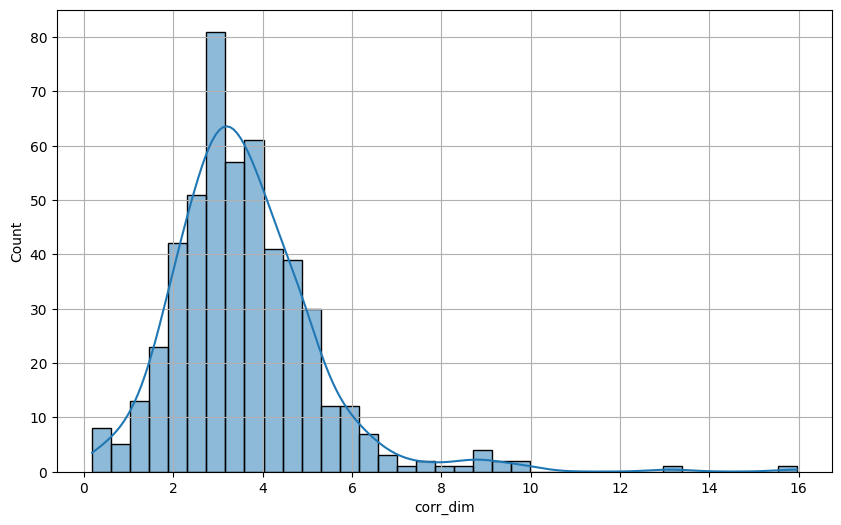

In [ ]:
plt.figure(figsize=(10,6))
sns.histplot(measures_df['corr_dim'], kde=True)
plt.grid()

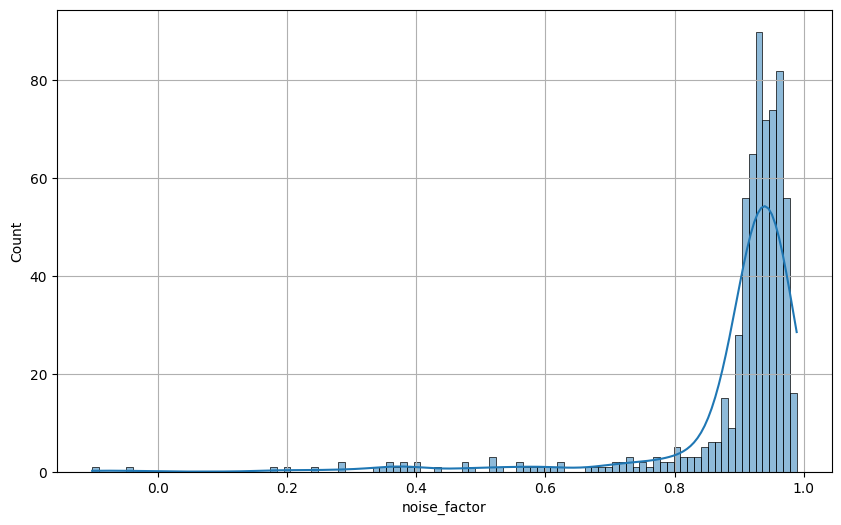

In [55]:
plt.figure(figsize=(10,6))
sns.histplot(measures_df['noise_factor'], kde=True)
plt.grid()

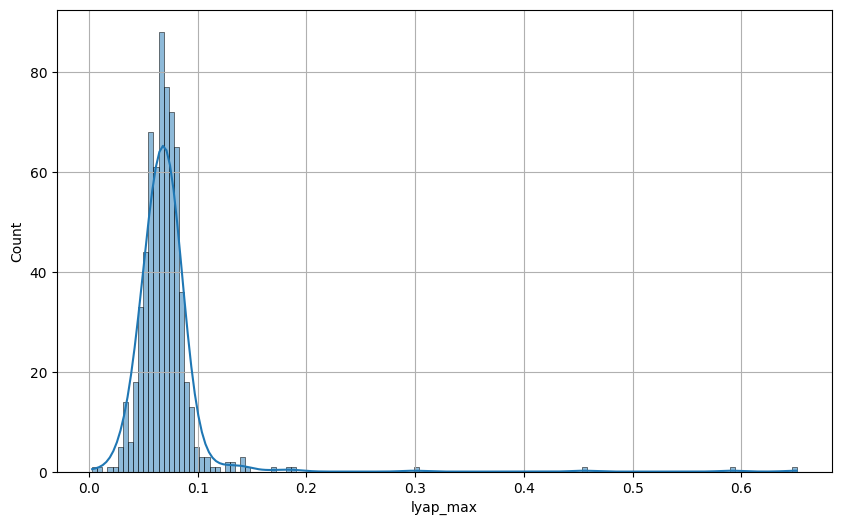

In [56]:
plt.figure(figsize=(10,6))
sns.histplot(measures_df['lyap_max'], kde=True)
plt.grid()

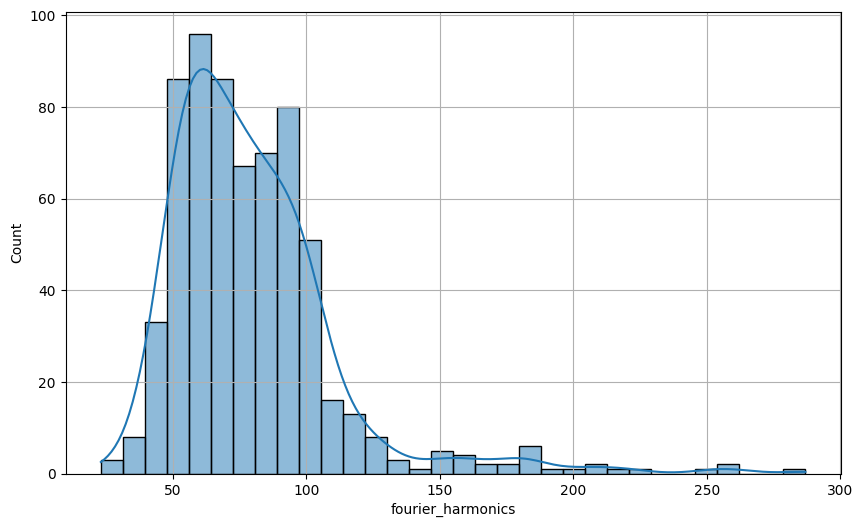

In [57]:
plt.figure(figsize=(10,6))
sns.histplot(measures_df['fourier_harmonics'], kde=True)
plt.grid()

# Predictions

In [74]:
def train_test(x, test_step):
    X_train = x[:-test_step]
    Y_train = x[1:-test_step+1]
    y_test = x[-test_step:]

    return X_train, Y_train, y_test

## LightGBM

In [91]:
from lightgbm import LGBMRegressor
import warnings
from sklearn.exceptions import DataConversionWarning

# ignore just the specific DataConversionWarning
warnings.filterwarnings("ignore", category=DataConversionWarning)

# ignore the “X does not have valid feature names” UserWarning
warnings.filterwarnings(
    "ignore",
    message="X does not have valid feature names"
)


l_res_lgbm = []
for ts in tqdm(measures_df['series']):
    lgbm = LGBMRegressor(random_state=23, verbosity=-1)
    l_res_ts = []
    for i in range(10, -1, -1):
        X_train, Y_train, y_test = train_test(time_series_df[ts], test_step=10+i)
        lgbm = lgbm.fit(X_train.values.reshape(-1,1), Y_train.values.ravel())
        
        cur = Y_train.values[-1]
        preds = []
        for j in range(10):
            cur = lgbm.predict(cur.reshape(1, -1)).reshape(-1, 1)[0]
            preds.append(cur)
        
        l_res_ts.append(mean_absolute_percentage_error(y_test[:10], preds)*100)
    
    l_res_lgbm.append(np.mean(l_res_ts))
measures_df['mape_lgbm'] = l_res_lgbm

100%|██████████| 650/650 [29:53<00:00,  2.76s/it]


/Users/roman14/Downloads/Reservoir-Computing-Investigation/.venv/lib/python3.12/site-packages/seaborn/_base.py:1608: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


Text(0, 0.5, 'MAPE, %')

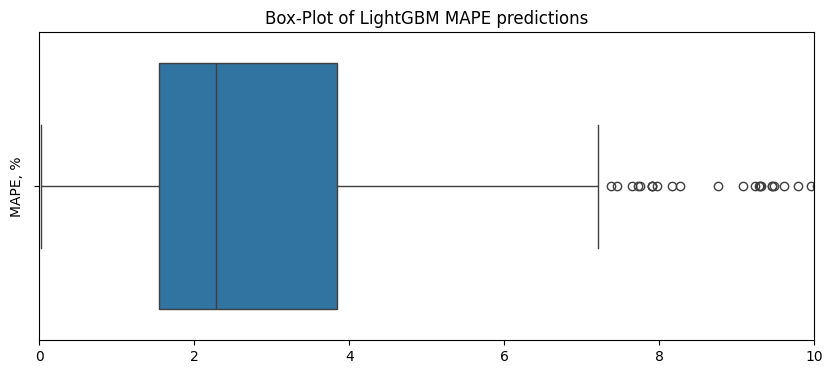

In [ ]:
plt.figure(figsize=(10,4))
sns.boxplot(x=l_res_lgbm, orient="x")
plt.title('Box-Plot of LightGBM MAPE predictions')
plt.xlim((0,10))
plt.ylabel('MAPE, %')

In [99]:
round(np.mean(l_res_lgbm),2)

np.float64(4.68)

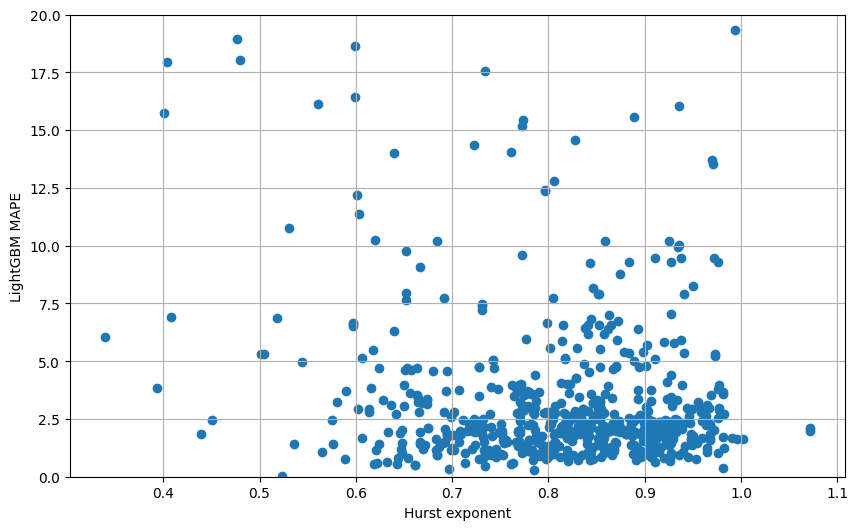

In [ ]:
plt.figure(figsize=(10,6))
plt.scatter(measures_df['hurst'], measures_df['mape_lgbm'])
plt.xlabel('Hurst exponent')
plt.ylabel('LightGBM MAPE')
plt.ylim((0,20))
plt.grid()

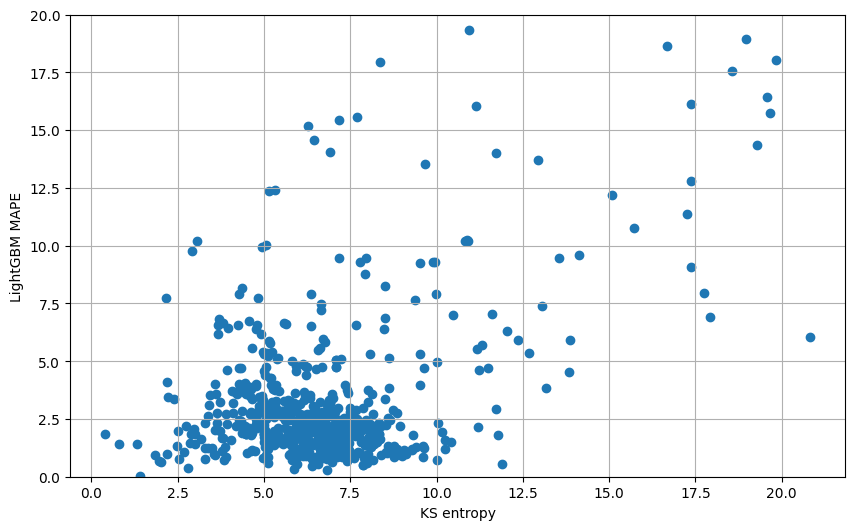

In [117]:
plt.figure(figsize=(10,6))
plt.scatter(measures_df['ks_entropy'], measures_df['mape_lgbm'])
plt.xlabel('KS entropy')
plt.ylabel('LightGBM MAPE')
plt.ylim((0,20))
plt.grid()

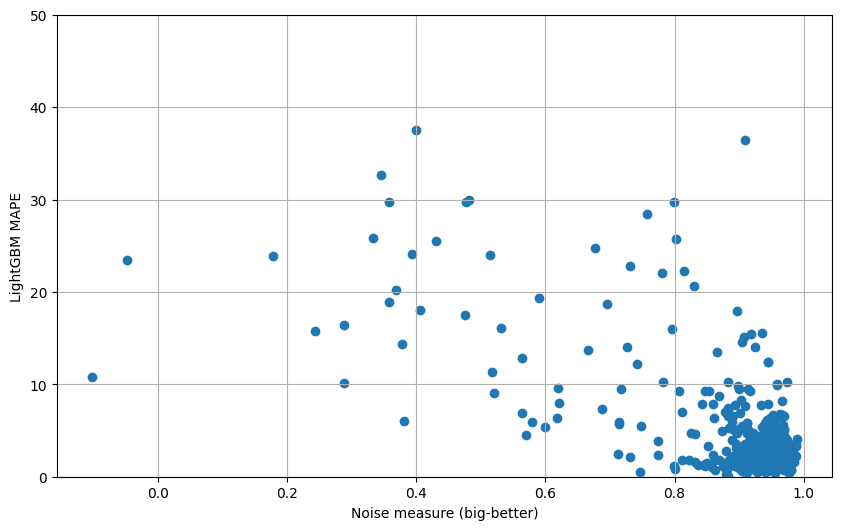

In [119]:
plt.figure(figsize=(10,6))
plt.scatter(measures_df['noise_factor'], measures_df['mape_lgbm'])
plt.xlabel('Noise measure (big-better)')
plt.ylabel('LightGBM MAPE')
plt.ylim((0,50))
plt.grid()

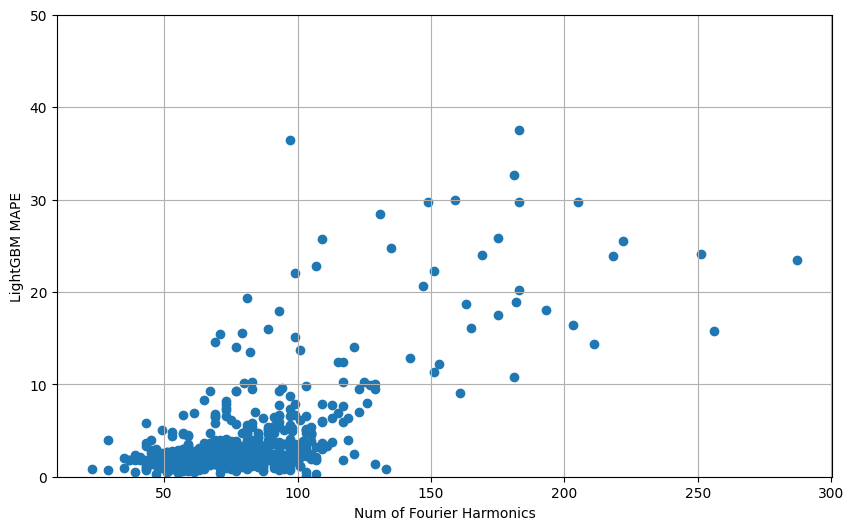

In [122]:
plt.figure(figsize=(10,6))
plt.scatter(measures_df['fourier_harmonics'], measures_df['mape_lgbm'])
plt.xlabel('Num of Fourier Harmonics')
plt.ylabel('LightGBM MAPE')
plt.ylim((0,50))
plt.grid()

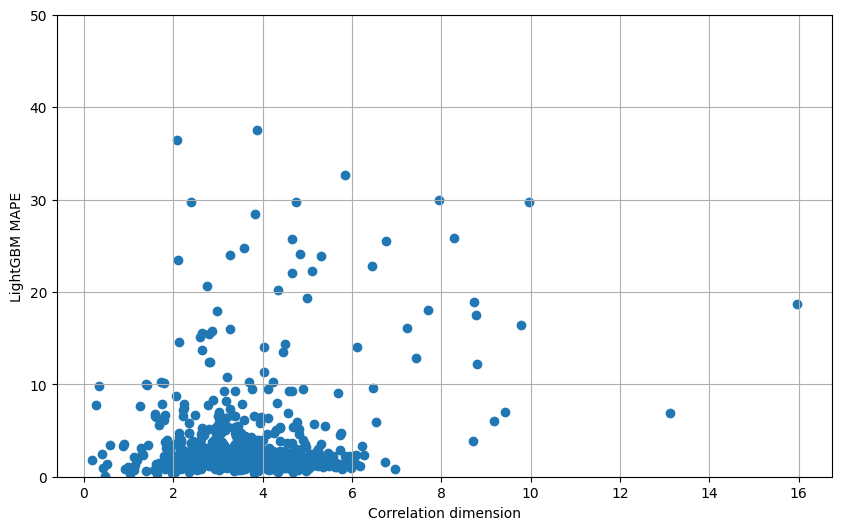

In [121]:
plt.figure(figsize=(10,6))
plt.scatter(measures_df['corr_dim'], measures_df['mape_lgbm'])
plt.xlabel('Correlation dimension')
plt.ylabel('LightGBM MAPE')
plt.ylim((0,50))
plt.grid()

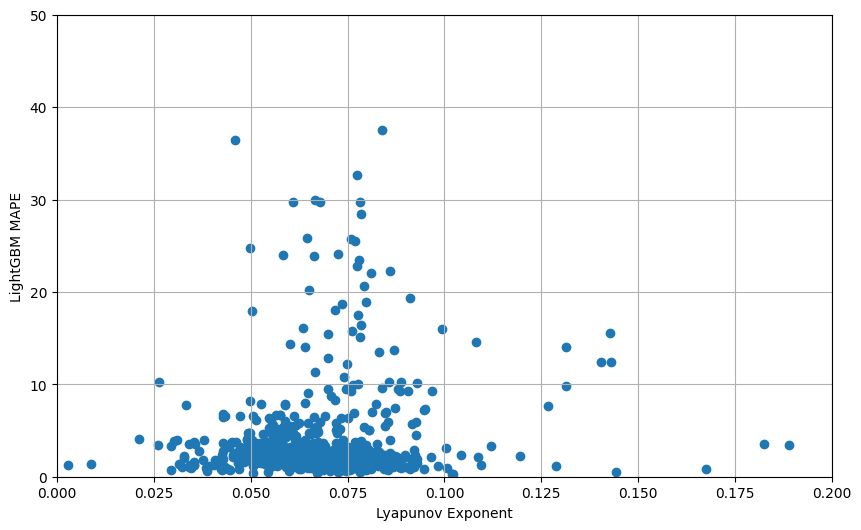

In [149]:
plt.figure(figsize=(10,6))
plt.scatter(measures_df['lyap_max'], measures_df['mape_lgbm'])
plt.xlabel('Lyapunov Exponent')
plt.ylabel('LightGBM MAPE')
plt.ylim((0,50))
plt.xlim((0, 0.2))
plt.grid()

## MSSA

In [241]:
from pymssa import MSSA

l_res_mssa = []
for ts in tqdm(measures_df['series']):
    mssa = MSSA(verbose=False)
    l_res_ts = []
    for i in range(10, -1, -1):
        _, _, y_test = train_test(time_series_df[ts], test_step=10+i)
        mssa.fit(time_series_df[ts][:-10-i])

        preds = mssa.forecast(10).ravel()

        l_res_ts.append(mean_absolute_percentage_error(y_test[:10], preds)*100)
    
    l_res_mssa.append(np.mean(l_res_ts))
measures_df['mape_mssa'] = l_res_mssa

100%|██████████| 650/650 [12:51<00:00,  1.19s/it]


Text(0, 0.5, 'MAPE, %')

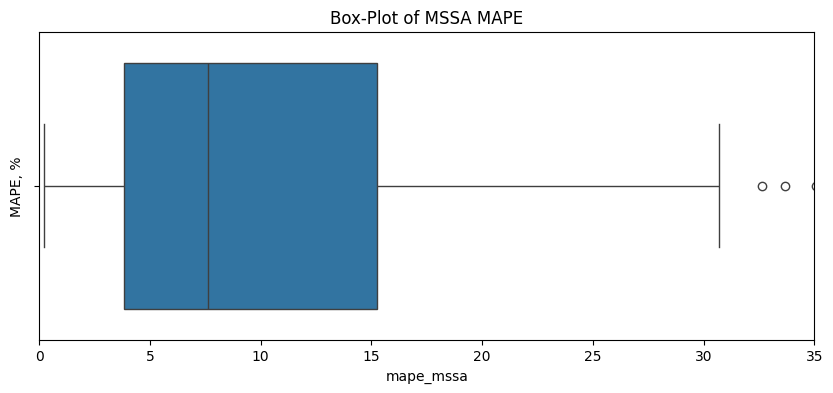

In [246]:
plt.figure(figsize=(10,4))
sns.boxplot(x=measures_df['mape_mssa'], orient="x")
plt.title('Box-Plot of MSSA MAPE')
plt.xlim((0,35))
plt.ylabel('MAPE, %')

In [243]:
round(np.mean(measures_df['mape_mssa']),2)

np.float64(1986.08)

## Prophet

In [191]:
from prophet import Prophet
import warnings

# Silence warnings from Prophet
warnings.filterwarnings('ignore')

def prepare_prophet_df(series, start, freq):
    """Convert your numeric series to a DataFrame compatible with Prophet."""
    df = pd.DataFrame({
        'ds': pd.date_range(start=start, periods=len(series), freq=freq),
        'y': series
    })
    return df

def determine_freq(ts, starting_date):
    if ts.startswith('H'):
        freq ='H'
    elif ts.startswith('D'):
        freq = 'D'
    elif ts.startswith('W'):
        wd = pd.to_datetime(starting_date, dayfirst=True).weekday()
        freq = ['W-MON','W-TUE','W-WED','W-THU','W-FRI','W-SAT','W-SUN'][wd]
    elif ts.startswith('M'):
        if pd.to_datetime(starting_date, dayfirst=True).day > 1:
            freq = 'ME'
        else:
            freq = 'MS'
    elif ts.startswith('Q'):
        if pd.to_datetime(starting_date, dayfirst=True).day > 1:
            freq = 'QE'
        else:
            freq = 'QS'
    elif ts.startswith('Y'):
        if pd.to_datetime(starting_date, dayfirst=True).day > 1:
            freq = 'YE'
        else:
            freq = 'YS'

    return freq

l_res_prophet = []

for ts in tqdm(measures_df['series']):
    l_res_ts = []

    # Fetch your time series and remove NaNs
    series_data = time_series_df[ts].dropna().values

    for i in range(10, -1, -1):
        test_step = 10 + i
        train_series = series_data[:-test_step]
        y_test = series_data[-test_step:][:10]

        # Prepare data for Prophet
        starting_date = m4_datasets['StartingDate'].loc[m4_datasets['M4id'] == ts].item()
        freq = determine_freq(ts, starting_date)
        train_df = prepare_prophet_df(train_series, start=starting_date, freq=freq)

        # Initialize and fit the Prophet model
        model = Prophet()
        model.fit(train_df)

        # Predict 10 future steps
        future = model.make_future_dataframe(periods=10, freq=freq)  # or your appropriate frequency
        forecast = model.predict(future)

        preds = forecast['yhat'].values[-10:]  # Take last 10 predictions

        # Evaluate predictions
        mape = mean_absolute_percentage_error(y_test, preds) * 100
        l_res_ts.append(mape)

    l_res_prophet.append(np.mean(l_res_ts))

measures_df['mape_prophet'] = l_res_prophet


00:29:05 - cmdstanpy - INFO - Chain [1] start processing
00:29:05 - cmdstanpy - INFO - Chain [1] done processing
00:29:05 - cmdstanpy - INFO - Chain [1] start processing
00:29:05 - cmdstanpy - INFO - Chain [1] done processing
 80%|███████▉  | 519/650 [24:47<06:32,  2.99s/it]00:29:05 - cmdstanpy - INFO - Chain [1] start processing
00:29:05 - cmdstanpy - INFO - Chain [1] done processing
00:29:05 - cmdstanpy - INFO - Chain [1] start processing
00:29:06 - cmdstanpy - INFO - Chain [1] done processing
00:29:06 - cmdstanpy - INFO - Chain [1] start processing
00:29:06 - cmdstanpy - INFO - Chain [1] done processing
00:29:06 - cmdstanpy - INFO - Chain [1] start processing
00:29:06 - cmdstanpy - INFO - Chain [1] done processing
00:29:06 - cmdstanpy - INFO - Chain [1] start processing
00:29:07 - cmdstanpy - INFO - Chain [1] done processing
00:29:07 - cmdstanpy - INFO - Chain [1] start processing
00:29:07 - cmdstanpy - INFO - Chain [1] done processing
00:29:07 - cmdstanpy - INFO - Chain [1] start p

Text(0, 0.5, 'MAPE, %')

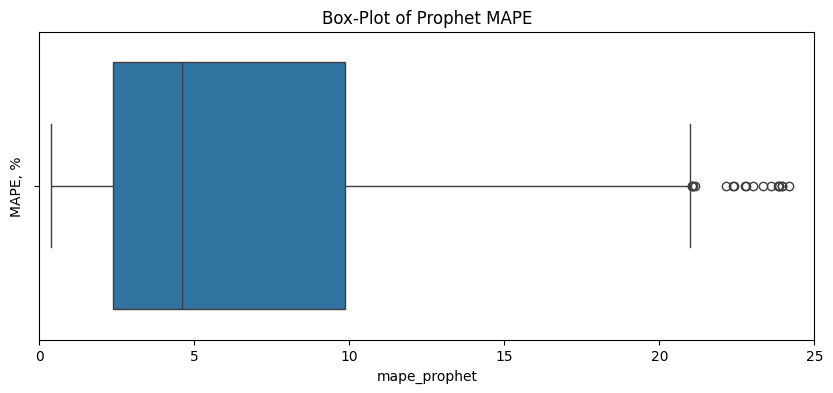

In [196]:
plt.figure(figsize=(10,4))
sns.boxplot(x=measures_df['mape_prophet'], orient="x")
plt.title('Box-Plot of Prophet MAPE')
plt.xlim((0,25))
plt.ylabel('MAPE, %')

In [197]:
round(np.mean(measures_df['mape_prophet']),2)

np.float64(9.95)

## ESN

In [159]:
import reservoirpy as rpy
from reservoirpy.nodes import Ridge, Reservoir
rpy.verbosity(0)  # no need to be too verbose here
rpy.set_seed(23)  # make everything reproducible!

units = 100
leak_rate = 0.3
spectral_radius = 0.9
input_scaling = 1.0
connectivity = 0.1
input_connectivity = 0.2
regularization = 1e-8
seed = 23

def reset_esn():
    reservoir = Reservoir(units, input_scaling=input_scaling, sr=spectral_radius,
                        lr=leak_rate, rc_connectivity=connectivity,
                        input_connectivity=input_connectivity, seed=seed)

    readout = Ridge(ridge=regularization)

    return reservoir >> readout

In [ ]:
# l_res_esn = []
# for ts in tqdm(measures_df['series']):
#     l_res_ts = []
#     for i in range(10, -1, -1):
#         X_train, Y_train, y_test = train_test(time_series_df[ts], test_step=10+i)
#         esn = reset_esn()
#         esn = esn.fit(X_train.values.reshape(-1, 1), Y_train.values.reshape(-1, 1))
        
#         cur = Y_train.values.reshape(-1, 1)[-1]
#         preds = []
#         for j in range(10):
#             cur = esn.run(cur).ravel()[0]
#             preds.append(cur)
        
#         l_res_ts.append(mean_absolute_percentage_error(y_test[:10], preds)*100)
    
#     l_res_esn.append(np.mean(l_res_ts))
# measures_df['mape_esn'] = l_res_esn

100%|██████████| 650/650 [26:16<00:00,  2.43s/it]


In [ ]:
# Function to compute log-returns
def to_log_return(x):
    return np.diff(np.log(x))

# Function to reconstruct original prices from log-returns
def from_log_return(last_known_value, log_returns):
    return last_known_value * np.exp(np.cumsum(log_returns))

l_res_esn = []

for ts in tqdm(measures_df['series']):
    l_res_ts = []
    series_data = time_series_df[ts].dropna().values

    for i in range(10, -1, -1):
        test_step = 10 + i
        
        # split data into train-test
        train_raw = series_data[:-test_step]
        y_test_real = series_data[-test_step:][:10]

        # convert train data to log-returns
        train_log_returns = to_log_return(train_raw)

        # ESN training (assuming reset_esn gives a correctly initialized ESN model)
        esn = reset_esn()
        
        # prepare inputs for ESN (X_train and Y_train as sequential data)
        X_train = train_log_returns[:-1].reshape(-1, 1)
        Y_train = train_log_returns[1:].reshape(-1, 1)
        
        esn.fit(X_train, Y_train)

        # Forecasting
        preds_log_return = []
        current_input = Y_train[-1].reshape(1, -1)

        for j in range(10):
            pred_log_ret = esn.run(current_input).item()
            preds_log_return.append(pred_log_ret)
            current_input = np.array([[pred_log_ret]])

        # reconstruct predictions from log-returns to real data
        preds_real = from_log_return(train_raw[-1], preds_log_return)

        # calculate MAPE on real data
        mape = mean_absolute_percentage_error(y_test_real, preds_real) * 100
        l_res_ts.append(mape)

    l_res_esn.append(np.mean(l_res_ts))
    
    measures_df['mape_esn'] = l_res_esn

100%|██████████| 650/650 [27:56<00:00,  2.58s/it]


Text(0, 0.5, 'MAPE, %')

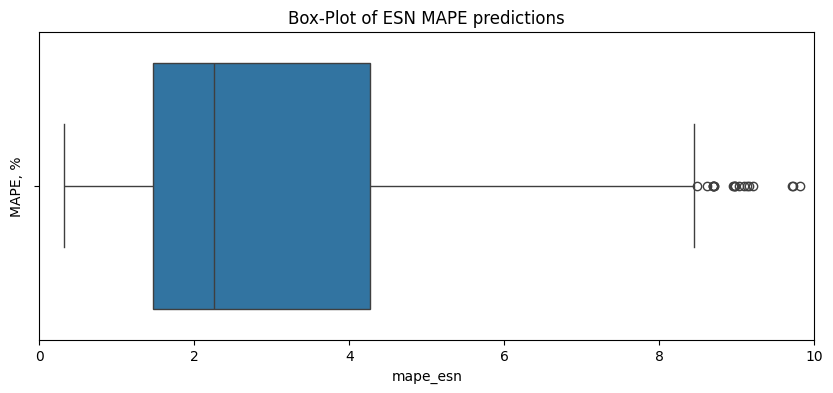

In [204]:
plt.figure(figsize=(10,4))
sns.boxplot(x=measures_df['mape_esn'], orient="x")
plt.title('Box-Plot of ESN MAPE predictions')
plt.xlim((0,10))
plt.ylabel('MAPE, %')

In [201]:
round(np.mean(l_res_esn),2)

np.float64(5.37)

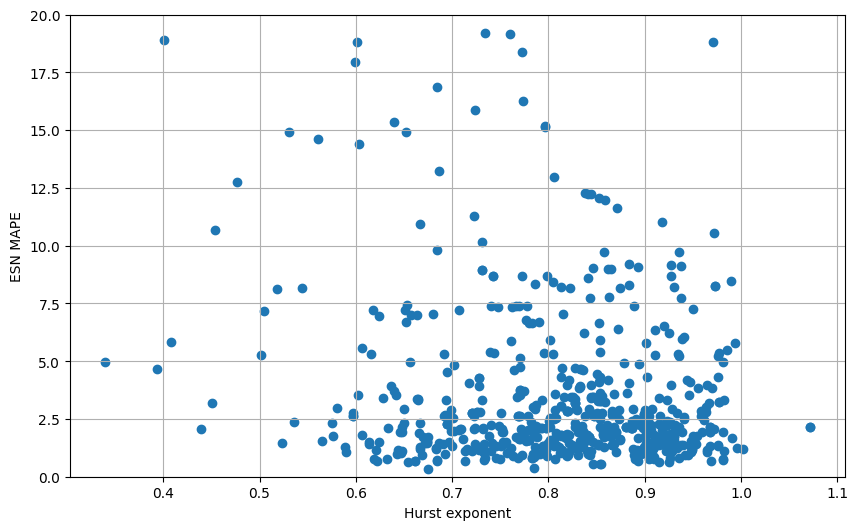

In [205]:
plt.figure(figsize=(10,6))
plt.scatter(measures_df['hurst'], l_res_esn)
plt.xlabel('Hurst exponent')
plt.ylabel('ESN MAPE')
plt.ylim((0,20))
plt.grid()

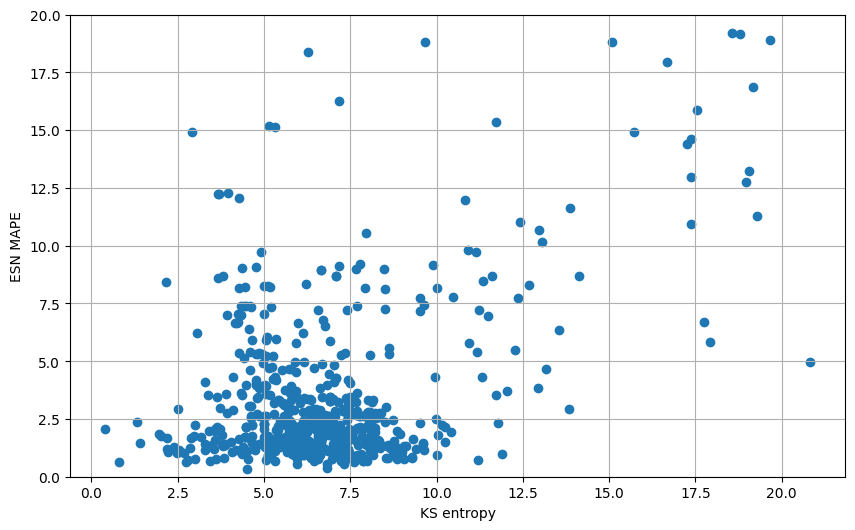

In [206]:
plt.figure(figsize=(10,6))
plt.scatter(measures_df['ks_entropy'], l_res_esn)
plt.xlabel('KS entropy')
plt.ylabel('ESN MAPE')
plt.ylim((0,20))
plt.grid()

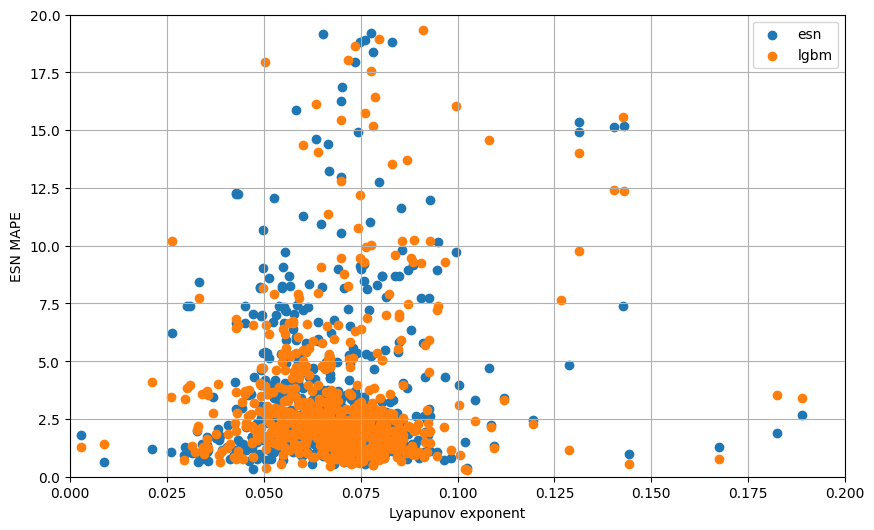

In [207]:
plt.figure(figsize=(10,6))
plt.scatter(measures_df['lyap_max'], l_res_esn, label='esn')
plt.scatter(measures_df['lyap_max'], l_res_lgbm, label='lgbm')
plt.xlabel('Lyapunov exponent')
plt.ylabel('ESN MAPE')
plt.ylim((0,20))
plt.xlim((0,0.2))
plt.legend()
plt.grid()

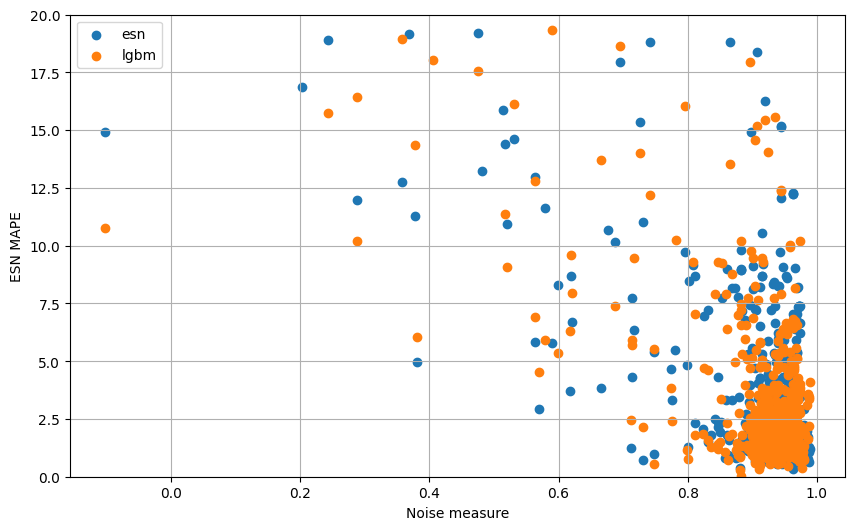

In [208]:
plt.figure(figsize=(10,6))
plt.scatter(measures_df['noise_factor'], l_res_esn, label='esn')
plt.scatter(measures_df['noise_factor'], l_res_lgbm, label='lgbm')
plt.xlabel('Noise measure')
plt.ylabel('ESN MAPE')
plt.ylim((0,20))
plt.legend()
plt.grid()

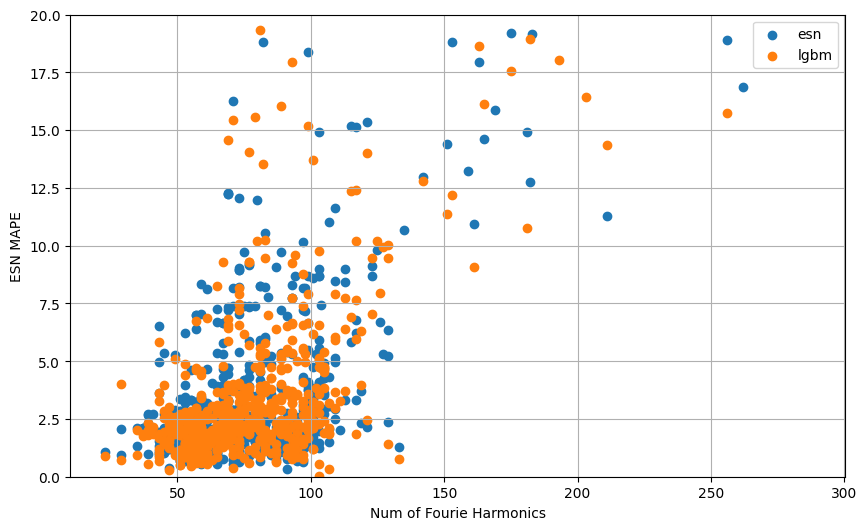

In [209]:
plt.figure(figsize=(10,6))
plt.scatter(measures_df['fourier_harmonics'], l_res_esn, label='esn')
plt.scatter(measures_df['fourier_harmonics'], l_res_lgbm, label='lgbm')
plt.xlabel('Num of Fourie Harmonics')
plt.ylabel('ESN MAPE')
plt.ylim((0,20))
plt.legend()
plt.grid()

## Fourie ESN

In [228]:
from sklearn.linear_model import Ridge as Ridge_sklearn
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

class EnhancedESN_FAN:
    def __init__(self,
                 input_dim,
                 reservoir_size=100,
                 spectral_radius=0.9,
                 sparsity=0.1,
                 ridge_alpha=1.0,
                 poly_order=2,
                 fan_dp=5,
                 seed=23):
        """
        input_dim : dimensionality of X (features per timestep)
        fan_dp    : number of Fourier terms (dp in the FAN paper)
        """
        np.random.seed(seed)
        self.reservoir_size = reservoir_size
        self.poly = PolynomialFeatures(degree=poly_order, include_bias=False)
        self.fan_dp = fan_dp

        # placeholders; actual Win/W init happens in fit()
        self.Win = None
        self.W   = None

        self.spectral_radius = spectral_radius
        self.sparsity = sparsity

        self.ridge = Ridge_sklearn(alpha=ridge_alpha)
        self.scaler = StandardScaler()
        self.input_scaler = StandardScaler()

    def initialize_weights(self, X):
        # input‐distribution aware Win
        inp_mean, inp_std = X.mean(axis=0), X.std(axis=0)
        mu, sigma = inp_mean.mean(), inp_std.mean()
        self.Win = np.random.normal(mu, sigma, (self.reservoir_size, X.shape[1] + 1))

        # sparse W with spectral radius
        W = np.random.rand(self.reservoir_size, self.reservoir_size) - 0.5
        W[np.random.rand(*W.shape) > self.sparsity] = 0
        W *= self.spectral_radius / np.max(np.abs(np.linalg.eigvals(W)))
        self.W = W

    def _update(self, state, u):
        # standard ESN update
        pre = self.Win @ np.concatenate(([1], u)) + self.W @ state
        return np.tanh(pre)

    def _fourier_features(self, X):
        # X: (n_samples, n_features)
        # return: (n_samples, 2*fan_dp*n_features)
        # FAN: explicit Fourier series terms sin(2πk x), cos(2πk x)
        features = []
        for k in range(1, self.fan_dp + 1):
            features.append(np.sin(2 * np.pi * k * X))
            features.append(np.cos(2 * np.pi * k * X))
        return np.hstack(features)
    
    # def _fft_features(self, X, n_coeffs):
    #     # X: (T, n) time series
    #     # return first n_coeffs magnitudes per dimension
    #     coeffs = np.abs(fft(X, axis=0))[:n_coeffs]  # shape (n_coeffs, n)
    #     return np.tile(coeffs.flatten(), (X.shape[0], 1))

    def fit(self, X, y):
        """
        X: shape (T, input_dim)
        y: shape (T,) or (T, output_dim)
        """
        # init reservoir
        self.initialize_weights(X)

        # collect reservoir states
        T = X.shape[0]
        states = np.zeros((T, self.reservoir_size))
        state = np.zeros(self.reservoir_size)
        for t in range(T):
            state = self._update(state, X[t])
            states[t] = state

        X_scaled = self.input_scaler.fit_transform(X)
        # polynomial features
        P = self.poly.fit_transform(X_scaled)
        # Fourier analysis network features
        F = self._fourier_features(X_scaled)

        # # combine all
        # H = np.hstack([states, P, F])

        # # scale & fit readout
        # Hs = self.scaler.fit_transform(H)
        # self.ridge.fit(Hs, y)

        H = np.hstack([states, P, F])
        self.scaler.fit(H)
        # prevent division by zero in .transform()
        self.scaler.scale_[self.scaler.scale_ == 0.0] = 1.0
        Hs = self.scaler.transform(H)
        self.ridge.fit(Hs, y)


    def predict(self, X, generative_steps=None):
        """
        If X is (T, input_dim) and generative_steps is None, this is open-loop:
          returns readout(X)
        If generative_steps is an int > 0, we perform:
          - use X[-1] as u0, then recursively predict next u's.
        """
        if generative_steps is None:
            # one‐shot prediction (teacher forcing)
            T = X.shape[0]
            states = np.zeros((T, self.reservoir_size))
            state = np.zeros(self.reservoir_size)
            for t in range(T):
                state = self._update(state, X[t])
                states[t] = state

            P = self.poly.transform(X)
            F = self._fourier_features(X)
            H = np.hstack([states, P, F])
            Hs = self.scaler.transform(H)
            return self.ridge.predict(Hs)

        # generative forecasting
        u = X[-1].copy()      # last observed input
        state = np.zeros(self.reservoir_size)
        preds = []
        for _ in range(generative_steps):
            state = self._update(state, u.reshape(-1))
            # build feature row
            # P = self.poly.transform(u.reshape(1, -1))
            # F = self._fourier_features(u.reshape(1, -1))
            u_scaled = self.input_scaler.transform(u.reshape(1, -1))
            P = self.poly.transform(u_scaled)
            F = self._fourier_features(u_scaled)
            h = np.hstack([state, P.ravel(), F.ravel()]).reshape(1, -1)
            h_s = self.scaler.transform(h)
            u_next = self.ridge.predict(h_s)
            preds.append(u_next.ravel())
            u = u_next  # feed back

        return np.vstack(preds)

In [230]:
l_res_fourie_esn = []
for ts in tqdm(measures_df['series']):
    l_res_ts = []
    for i in range(10, -1, -1):
        X_train, Y_train, y_test = train_test(time_series_df[ts], test_step=10+i)
        esn_fan = EnhancedESN_FAN(input_dim=1)
        esn_fan.fit(X=X_train.values.reshape(-1,1), y=Y_train.values.reshape(-1,1))
        
        preds = esn_fan.predict(Y_train.values.reshape(-1,1), generative_steps=10)
        
        l_res_ts.append(mean_absolute_percentage_error(y_test[:10], preds)*100)
    
    l_res_fourie_esn.append(np.mean(l_res_ts))
measures_df['mape_esn_fan'] = l_res_fourie_esn

100%|██████████| 650/650 [01:28<00:00,  7.34it/s]


Text(0, 0.5, 'MAPE, %')

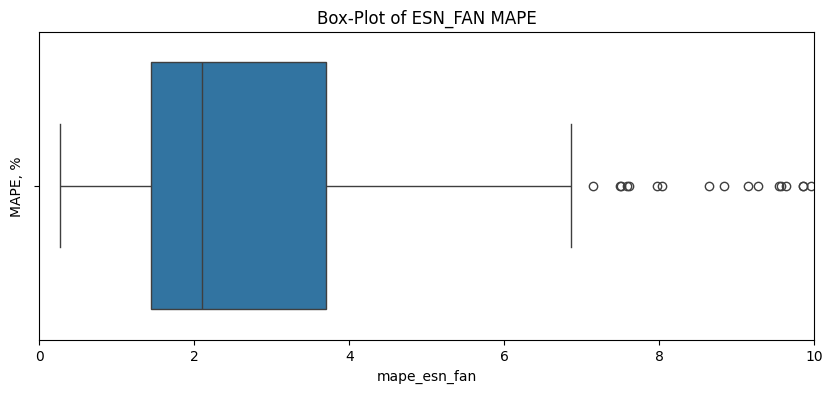

In [231]:
plt.figure(figsize=(10,4))
sns.boxplot(x=measures_df['mape_esn_fan'], orient="x")
plt.title('Box-Plot of ESN_FAN MAPE')
plt.xlim((0,10))
plt.ylabel('MAPE, %')

In [232]:
round(np.mean(measures_df['mape_esn_fan']),2)

np.float64(4.45)

In [ ]:
# measures_df.to_csv('measures_df.csv', header=True)

# Box-plots

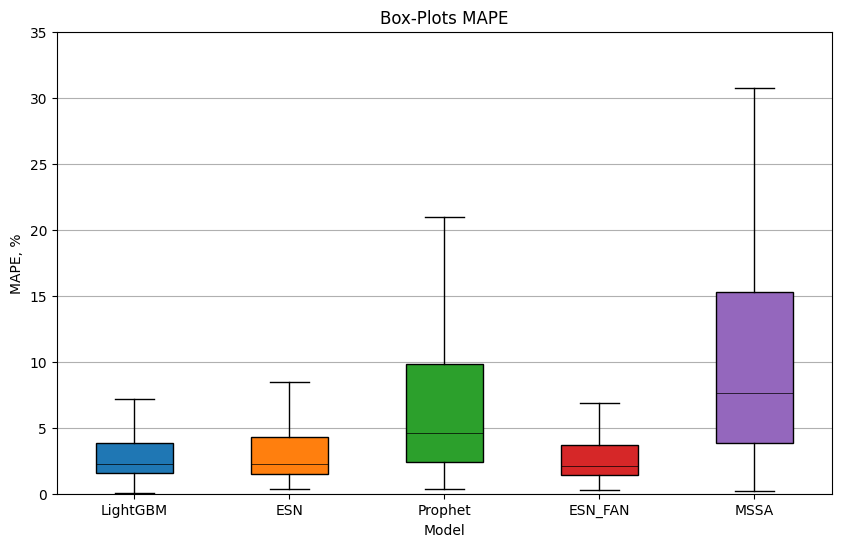

In [ ]:
plt.figure(figsize=(10,6))
box = plt.boxplot(measures_df[['mape_lgbm', 'mape_esn', 'mape_prophet',
       'mape_esn_fan', 'mape_mssa']].values, labels=['LightGBM', 'ESN', 'Prophet', 'ESN_FAN', 'MSSA'],
         patch_artist=True, showfliers=False, meanline=True)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Закрашиваем каждый ящик своим цветом
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

for median in box['medians']:
    median.set_color('black')  # Красный цвет медианы
    median.set_linewidth(0.5)  # Можно также изменить толщину

plt.title("Box-Plots MAPE")
plt.ylabel('MAPE, %')
plt.xlabel('Model')
plt.ylim((0,35))
plt.grid(axis='y')

In [275]:
print(round(np.median(measures_df['mape_lgbm']),2), round(np.median(measures_df['mape_esn_fan']),2), round(np.median(measures_df['mape_esn']),2))

2.28 2.09 2.25
